<a href="https://colab.research.google.com/github/1y33/Multiclass_Classification/blob/main/Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparams
N_CLASSES=5
N_FEATURES=2
RANDOM_STATE=36

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc



def plot_decision_boundary(model, X, y):
    # Convert tensors to NumPy arrays
    X = X.cpu().numpy()
    y = y.cpu().numpy()

    # Define plot boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

    # Make predictions
    with torch.no_grad():
        model.eval()
        if hasattr(model, 'predict_proba'):
            # For scikit-learn style models
            y_pred = model.predict_proba(grid_points).argmax(axis=1)
        else:
            # For other PyTorch models
            y_logits = model(grid_points)
            y_pred = y_logits.argmax(dim=1)

    # Reshape predictions and plot decision boundaries
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap="viridis", alpha=0.7)

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="viridis")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


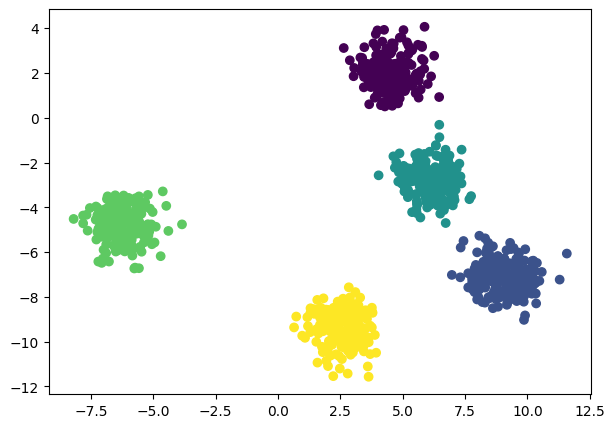

In [120]:
# Create our data set
X,y=make_blobs(n_samples=1000,
               n_features=2,
               centers=N_CLASSES,
               cluster_std=0.7,
               random_state=RANDOM_STATE)
# Create the train/test split
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.LongTensor)
X_test,X_train,y_test,y_train=train_test_split(X,
                                               y,
                                               train_size=0.2,
                                               random_state=RANDOM_STATE
                                               )

plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")

In [116]:
# Create a model
class ModelBlobs(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_sequential=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units*2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units*2,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_sequential(x)

model=ModelBlobs(input_features=2,output_features=5,hidden_units=16)
model

ModelBlobs(
  (linear_sequential): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

In [117]:
# Implementing an loss function and an optimizer
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

# Training and testing loop
epochs=1000
torch.manual_seed(RANDOM_STATE)

for epoch in range(epochs):
  model.train()
  # Creating preds
  y_logits=model(X_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  # Calculating loss and accuracy
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Evaluating our model
  model.eval()
  with torch.inference_mode():
    y_test_logits=model(X_test)
    y_test_pred=torch.softmax(y_test_logits,dim=1).argmax(dim=1)

    #Calculating the loss and the acc
    test_loss=loss_fn(y_test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=y_test_pred)
  if epoch % 100 == 0:
    print(f"Epoch:{epoch}| Loss:{loss:.4f}| Acc:{acc:.2f}| Test Loss:{test_loss:.4f}| Test Acc:{test_acc:.2f}")

Epoch:0| Loss:1.5634| Acc:24.50| Test Loss:1.5056| Test Acc:33.50
Epoch:100| Loss:0.0613| Acc:97.88| Test Loss:0.0799| Test Acc:95.50
Epoch:200| Loss:0.0439| Acc:98.50| Test Loss:0.0552| Test Acc:97.00
Epoch:300| Loss:0.0329| Acc:99.00| Test Loss:0.0346| Test Acc:98.50
Epoch:400| Loss:0.0282| Acc:99.00| Test Loss:0.0310| Test Acc:98.50
Epoch:500| Loss:0.0234| Acc:99.50| Test Loss:0.0246| Test Acc:99.50
Epoch:600| Loss:0.0161| Acc:99.75| Test Loss:0.0134| Test Acc:100.00
Epoch:700| Loss:0.0115| Acc:99.88| Test Loss:0.0091| Test Acc:100.00
Epoch:800| Loss:0.0068| Acc:100.00| Test Loss:0.0054| Test Acc:100.00
Epoch:900| Loss:0.0052| Acc:100.00| Test Loss:0.0044| Test Acc:100.00


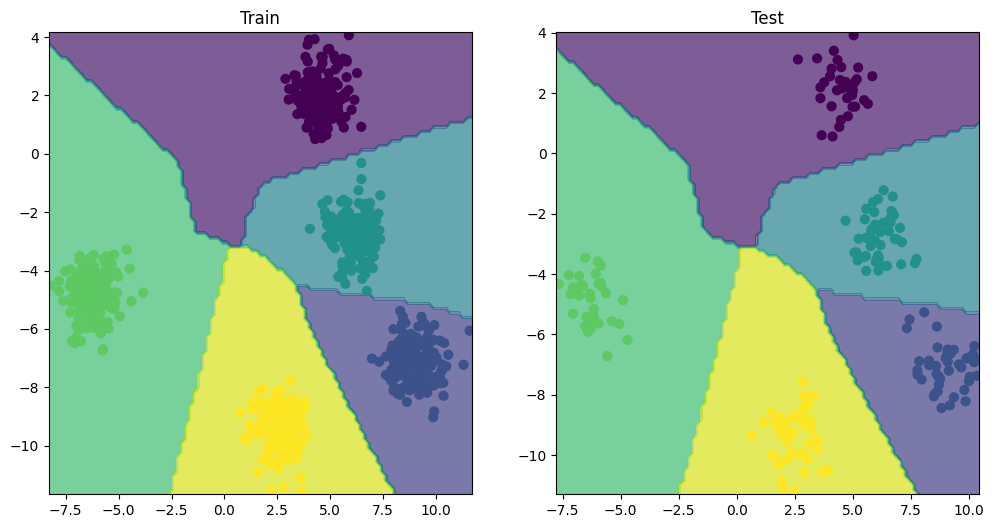

In [122]:
# Visualizing our data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_test,y_test)